<a href="https://colab.research.google.com/github/maxmatical/Reinforcement-Learning/blob/master/DQN_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
# plt.imshow(env.render('rgb_array'))
print("Observation space:", env.observation_space.shape)
print("Action space:", env.action_space)

Observation space: (4,)
Action space: Discrete(2)


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Experience Replay

In [0]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """
        
        Adds a tuple of (s, a, s', r) to memory for experience replay 
        
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None) # appends memory with 'None' to get [None, None, ...]
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1)%self.capacity

    def sample(self, bs):
        
        """samples from memory"""
        
        return random.sample(self.memory, bs)
    
    def __len__(self):
        return len(self.memory)

# Deep Q networks

In [0]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        """
        
        input shape should be (n_channels x h x w)
        
        """
        super(DQN, self).__init__()
        self.n_actions = n_actions
        self.input_shape = input_shape
        
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, stride = 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5, stride = 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size = 5, stride = 2)
        self.bn3 = nn.BatchNorm2d(32)
        self.linear = nn.Linear(self.feature_size(), n_actions)
        
    def forward(self, input):
        out = F.relu(self.bn1(self.conv1(input)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
        
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)
        
        

In [6]:
# Test to see if implemented correctly

tmp = torch.randn((16, 3, 32, 32)).to(device)
a = DQN((3, 32, 32), 2).to(device)
print(a(tmp).shape)


torch.Size([16, 2])


# Input Extraction

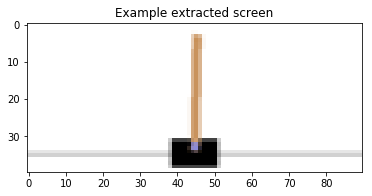

In [7]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    #print(screen.shape)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()


# Setting up training

- Initialize hyperparameters
- Create models
- Define utility functions

In [8]:
# Setting hyperparameters for the model

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()

_, n_channels, screen_height, screen_width = init_screen.shape

print('Input shape is', (n_channels, screen_height, screen_width))

n_actions = env.action_space.n
print('number of outputs is', n_actions)


Input shape is (3, 40, 90)
number of outputs is 2


In [0]:
# Defining our policy and target Q networks
# Policy_net is updated every step
# Target_net is updated every n steps

policy_net = DQN((n_channels, screen_height, screen_width), n_actions).to(device)
target_net = DQN((n_channels, screen_height, screen_width), n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr = 3e-4)

memory = ReplayMemory(capacity=10000)

steps_done = 0

def select_action(state):
    """
    
    selects an action based on e-greedy
    
    """
    
    global steps_done
    sample = random.random() #samples from uniform[0,1]
    current_eps = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY) #decay epsilon
    steps_done += 1
    if sample > current_eps:
        with torch.no_grad():
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was found,
        # so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    
    else: 
        return torch.tensor([[random.randrange(n_actions)]], \
                            device=device, dtype=torch.long) # returns random action
    
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


# Training Agent

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-terminal states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device = device, dtype=torch.uint8)
    
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]) # list of non-final next states

    state_batch = torch.cat(batch.state) # list of states in the batch
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    # Computes the Q values of the state-action pair
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    
    next_state_values = torch.zeros(BATCH_SIZE, device = device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach() # predicted using target_net
    
    # compute the expected Q value 
    expected_Q_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute hubert loss (better than L1/L2 loss)
    loss = F.smooth_l1_loss(state_action_values, expected_Q_values.unsqueeze(1))
    
    # update the weights of the model
    optimizer.zero_grad() 
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

        

## Training the agent

running_reward is the average duration of the last 100 episodes. The game is considered solved when the running_reward is >195



In [0]:
# n_episodes = 50
# for i_episode in range(n_episodes):
duration = 10
n_episodes = 1
running_reward = (duration * 0.99) + (n_episodes * 0.01)

while running_reward <195:
    n_episodes +=1
    env.reset() # initialize and reset the environment
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    for t in count():
        # perform an action and get a reward
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device = device)

        # observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # store transition in memory
        memory.push(state, action, next_state, reward)

        # optimize the policy_network
        optimize_model()
        if done:
            episode_durations.append(t + 1)
#             plot_durations()
           
            break
        
        
    duration = episode_durations[-1]
    running_reward = (duration * 0.99) + (n_episodes * 0.01)
    
    
    # update the target network by copyin the policy network
    if n_episodes% TARGET_UPDATE == 0 :
        target_net.load_state_dict(policy_net.state_dict())
        
    if n_episodes%500 ==0:
        print(running_reward)


print("Finished")
print(running_reward)
env.render()
env.close()
plt.ioff()
plt.show()

                

14.9
19.9
23.91
29.9
35.89
38.91
44.9
